# Heiner classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### TODO:

- What metrics to use during training?
- Which plots are needed?


### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import pandas as pd
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

#dirLoc = '../Data/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss"
#dirLoc = '../Data_3Fold/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss_3Fold"
dirLoc = '../Data_SUSY/'
name = "weights/ReLU_Baseline_CLR_AsimovLoss_SUSY"

name_pretrain = name.replace('weights/', 'weights/PRETRAIN_')

Using TensorFlow backend.


## Prep SUSY data

In [ ]:
from Modules.Data_Import import prepareSample, getPreProcPipes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

nFolds = 10
features = [
    'HT','MET','MT','MT2W','n_jet',
    'n_bjet','sel_lep_pt0','sel_lep_eta0','sel_lep_phi0',
    'selJet_phi0','selJet_pt0','selJet_eta0','selJet_m0',
    'selJet_phi1','selJet_pt1','selJet_eta1','selJet_m1',
    'selJet_phi2','selJet_pt2','selJet_eta2','selJet_m2',
]

df = pd.read_pickle('../../dfs/combinedleonid.pkl')
df.drop(columns=list(k for k in df.keys() if k not in features+['signal']), inplace=True)
df.rename(index=str, columns={"signal": "gen_target"}, inplace=True)
df['EventId'] = df.index.tolist()
df['gen_weight_original'] = 1.
df['gen_weight'] = 1.
df.fillna(0,inplace=True)

# 20% test, 16% validation, rest training
train, test = train_test_split(df, test_size=0.2, random_state=492)
train, val = train_test_split(train, test_size=0.2, random_state=492)

# a thing that's applied in Higgs analysis...
# convertData(trainingData, rotate, cartesian)
# convertData(test, rotate, cartesian)

data = {
    'train': train[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'val': val[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'test': test,
    'features': features
}

# rest copied from Modules.Data_Import.runDataImport:
inputPipe, _ = getPreProcPipes(normIn=True)
inputPipe.fit(data['train'][data['features']].values.astype('float32'))
with open(dirLoc + 'inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)

prepareSample(data['train'], 'train', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['val'], 'val', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['test'], 'testing', inputPipe, False, nFolds, data['features'], dirLoc)

with open(dirLoc + 'features.pkl', 'wb') as fout:
    pickle.dump(data['features'], fout)

## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training = True

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
lumi=30.
s_exp=228.195*0.14*lumi #leonid's number
b_exp=844000.*8.2e-4*lumi #cross section of ttbar sample in fb times efficiency measured by Marco

print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()

('\nTraining on', 21, 'features:', ['HT', 'MET', 'MT', 'MT2W', 'n_jet', 'n_bjet', 'sel_lep_pt0', 'sel_lep_eta0', 'sel_lep_phi0', 'selJet_phi0', 'selJet_pt0', 'selJet_eta0', 'selJet_m0', 'selJet_phi1', 'selJet_pt1', 'selJet_eta1', 'selJet_m1', 'selJet_phi2', 'selJet_pt2', 'selJet_eta2', 'selJet_m2'])
_S9d58ep02
_B2d08ep04


## Import data

In [5]:
trainData          = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r"))
trainDataTargetMod = BatchYielderTargetMod(h5py.File(dirLoc + 'train.hdf5', "r"))
nSplits = trainData.nFolds

## Determine LR

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`


______________________________________
Training finished
Cross-validation took 31.785s 


/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


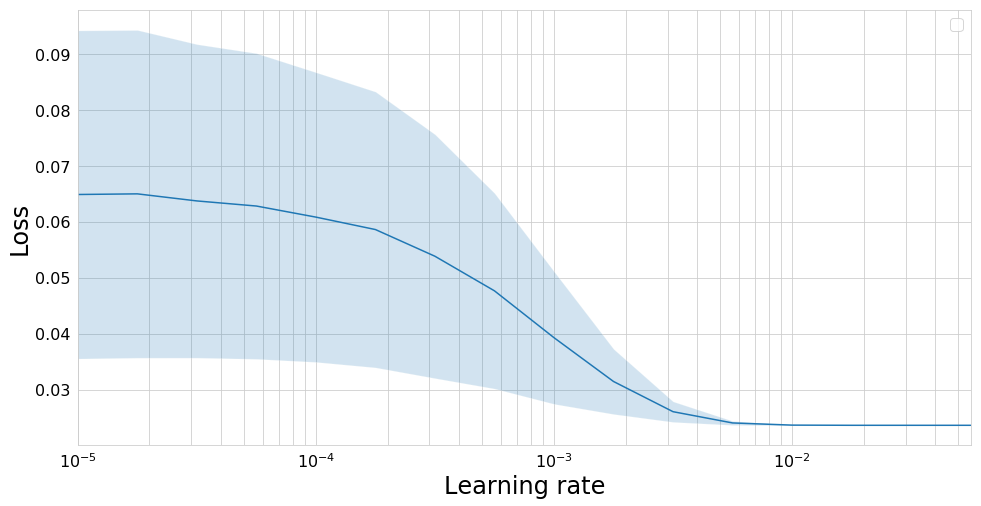

______________________________________



In [5]:
def my_model(**_):
    return model


newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 1e-3
trainParams['batch_size'] = 256
patience = 20  # is 50 above

#loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S9d58ep02_B2d08ep04']
loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
newModelArgs['compileArgs']['lr'] = 1e-10
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

# d = trainData
d = trainDataTargetMod

lrFinder = batchLRFind(d, getModel, newModelArgs, trainParams,# allFolds=False,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0, binary=True)

## Train classifier

<b>Asimov-significance-loss 0.5</b> training with ``maxEpochs``

In [7]:
def _get_s_b(s_exp, b_exp, y_true, y_pred):

    # unfold encoded weights
    weights = K.abs(y_true)
    s_weights = (weights + y_true)/2.
    b_weights = (weights - y_true)/2.

    s_exp_weight = s_exp/(K.sum(s_weights)+K.epsilon())
    b_exp_weight = b_exp/(K.sum(b_weights)+K.epsilon())

    s = s_exp_weight * K.sum(y_pred * s_weights)
    b = b_exp_weight * K.sum(y_pred * b_weights)
    return s, b

def asimovSignificanceLossInvert(syst_factr, s_exp=None, b_exp=None):
    '''Define a loss function that calculates the significance based on fixed
    expected signal and expected background yields for a given batch size

    s_exp and b_exp are the number of recorded signal and background events,
    respectively (xsec*lumi).'''

    #@_patch_with_weights
    def asimovSigLossInvert(y_true, y_pred):
        s, b = _get_s_b(s_exp, b_exp, y_true, y_pred)
        
        spb = s+b
        b2 = b*b
        syst = syst_factr * b
        syst2 = syst*syst
        bpsyst2 = b+syst2            
        return 0.5/(
            spb * K.log((spb*bpsyst2+K.epsilon())/(b2+spb*syst2+K.epsilon())+K.epsilon())
            -b2/(syst2+K.epsilon()) * K.log(1+syst2*s/(b*bpsyst2+K.epsilon()))
        )

    return asimovSigLossInvert

    
def get_losses_dict(syst_factors, s_exp=None, b_exp=None):
    post_fix  = ('_S%.2e'%s_exp) if s_exp else ''
    post_fix += ('_B%.2e'%b_exp) if b_exp else ''
    for before, after in (('.', 'd'), ('+','p'), ('-','m')):
        post_fix = post_fix.replace(before, after)

    d = {}
    d.update({
        (
            ('asimovSignificanceLossInvert_Sys%s'%sf).replace('.','p')+post_fix,
                asimovSignificanceLossInvert(sf, s_exp, b_exp)
        )
        for sf in syst_factors
    })

    # for keras to find the find the functions on load, the need to be named
    for func_name, func in d.iteritems():
        func.__name__ = func_name

    return d


new_loss_functions.update(get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp))

In [11]:
newModelArgs = modelParams.copy()
#loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S9d58ep02_B2d08ep04']
loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
newModelArgs['compileArgs']['lr'] = 1e-4
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

def newGetModel(**args):
    model = getModel(**newModelArgs)
    name = name_pretrain+'_model_step3p1'
    pre_model = load_model(name+'.h5', custom_objects=new_loss_functions)
    model.set_weights(pre_model.get_weights())
    return model

Using cosine annealing
Training using weights
Running fold 1 / 10
.
1 New best found: 0.00830269799849
.
2 New best found: 0.00826342913933
......
8 New best found: 0.0082622188331
...
11 New best found: 0.0082350967856
.........
20 New best found: 0.00821205810959
............
32 New best found: 0.00820989583895
..
34 New best found: 0.00819436078114
....
38 New best found: 0.00817538422959
...
41 New best found: 0.00816229209322
............
53 New best found: 0.00816062326862
............
65 New best found: 0.00813901798221
.....
70 New best found: 0.00813203410582
....
74 New best found: 0.00811747413362
.....
79 New best found: 0.00811543327043
....
83 New best found: 0.00810378662193
......
89 New best found: 0.00809707244936
.........
98 New best found: 0.00808732685801
....................Learning process stalled at 0.008102869870633916. Stopping...
........Learning process stalled at 0.008101206463512756. Stopping...
Score is: {'loss': 0.008087326858010115, 'AUC': 0.1754988151

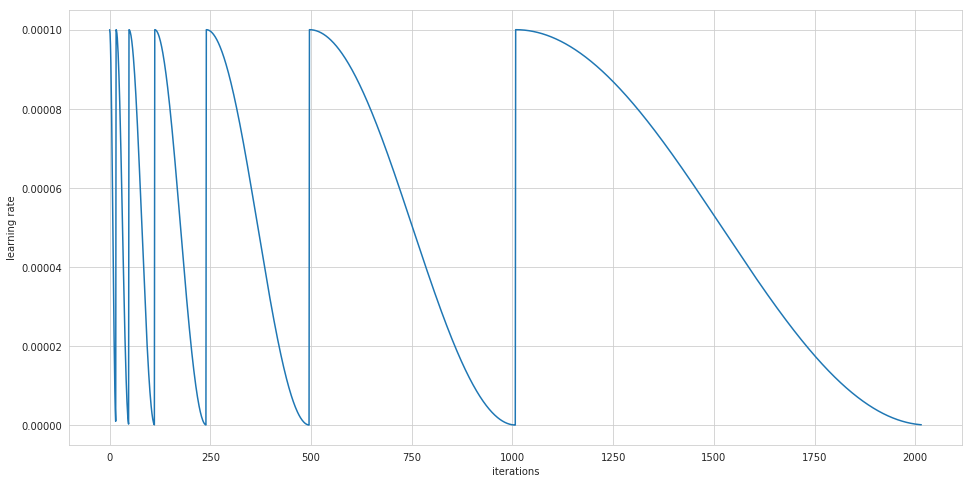

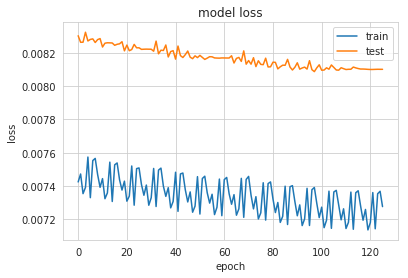

Fold took 1049.623s

Running fold 2 / 10
.
1 New best found: 0.197035929317
.........
10 New best found: 0.099925292239
......
16 New best found: 0.0839199886874
..
18 New best found: 0.0646862907235
.
19 New best found: 0.0553471521334
..
21 New best found: 0.0420098715331
..
23 New best found: 0.0410949416851
...
26 New best found: 0.0407622982237
.
27 New best found: 0.0391094867015
.
28 New best found: 0.0369084528631
.
29 New best found: 0.0361806315659
.
30 New best found: 0.0359407814989
....
34 New best found: 0.0342930644503
..
36 New best found: 0.0240971390849
...
39 New best found: 0.0189300068049
...
42 New best found: 0.0185418045087
.
43 New best found: 0.0183903215893
.
44 New best found: 0.0165870437773
.
45 New best found: 0.0151485500909
.
46 New best found: 0.013789051815
......
52 New best found: 0.0137815847691
..
54 New best found: 0.0130390487659
.
55 New best found: 0.0125086473382
.
56 New best found: 0.01243836457
........
64 New best found: 0.0112060501879
.

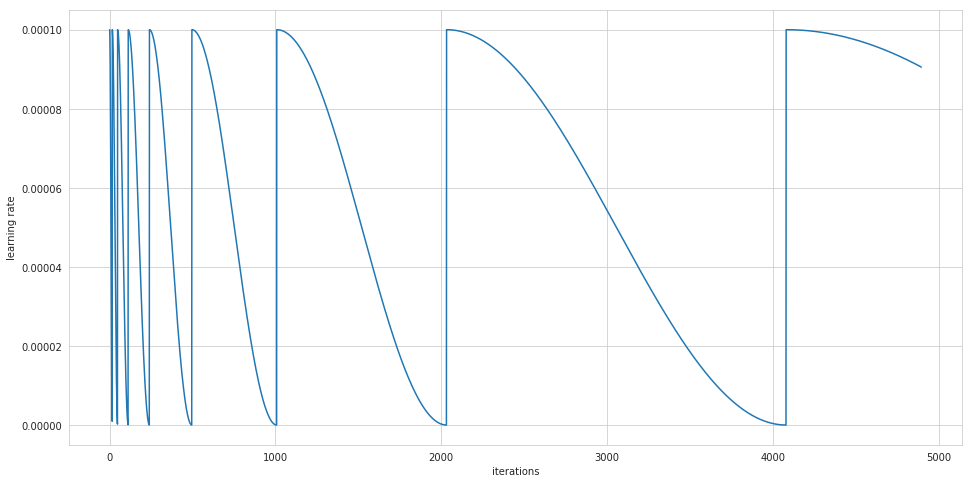

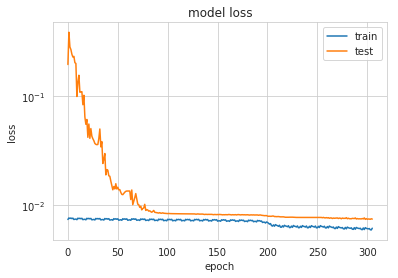

Fold took 2276.798s

Running fold 3 / 10
.
1 New best found: 1621982.98449
.
2 New best found: 1621973.5126
..............................Learning process stalled at 1622039.8159920678. Stopping...
.Learning process stalled at 1622045.0639226001. Stopping...
.Learning process stalled at 1622042.631968214. Stopping...
.Learning process stalled at 1622043.0159614687. Stopping...
.Learning process stalled at 1622044.8079265535. Stopping...
Score is: {'loss': 1621973.5125970924, 'AUC': 0.17529759376928422, 'cut': 0.04577351361513138, 'wAUC': 0.17529759376928422, 'AMS': 456.9326611648648}


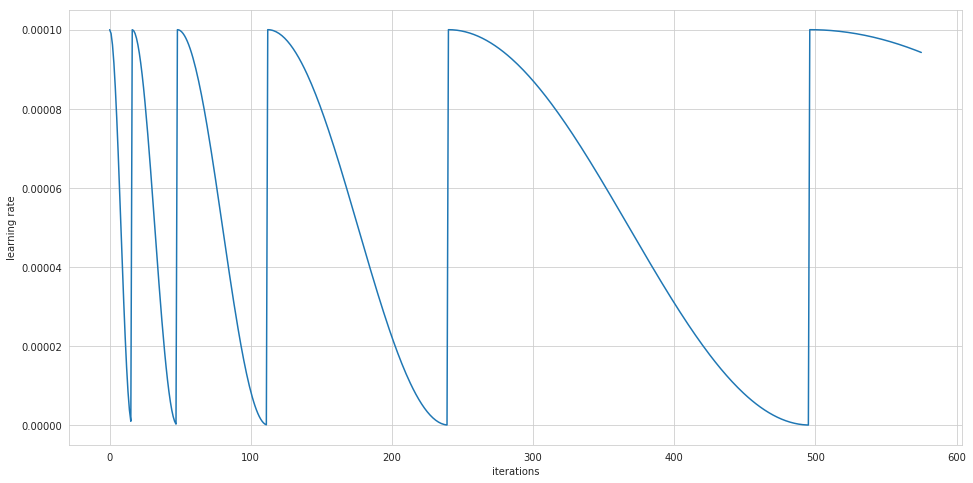

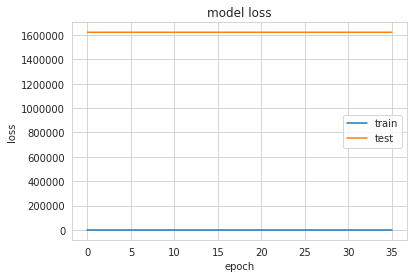

Fold took 320.725s

Running fold 4 / 10
.
1 New best found: 0.00855090520397
.
2 New best found: 0.00854379466214
....
6 New best found: 0.00853589752698
.
7 New best found: 0.00853086055716
.
8 New best found: 0.0085195281012
..
10 New best found: 0.00850008112576
........
18 New best found: 0.00849801511792
.
19 New best found: 0.00848362589697
.....
24 New best found: 0.00847763022321
....
28 New best found: 0.00847550917321
.
29 New best found: 0.00847310787038
....
33 New best found: 0.00845723933104
..
35 New best found: 0.00843657784734
.........
44 New best found: 0.00843259440796
..
46 New best found: 0.00842821894566
.........
55 New best found: 0.00842547933676
.........
64 New best found: 0.00840866152156
..Learning process stalled at 0.00844669743673876. Stopping...
....Learning process stalled at 0.008462882605846971. Stopping...
.
71 New best found: 0.0083972956349
.Score is: {'loss': 0.008397295634902548, 'AUC': 0.17632627362301923, 'cut': 0.04236063361167908, 'wAUC': 0

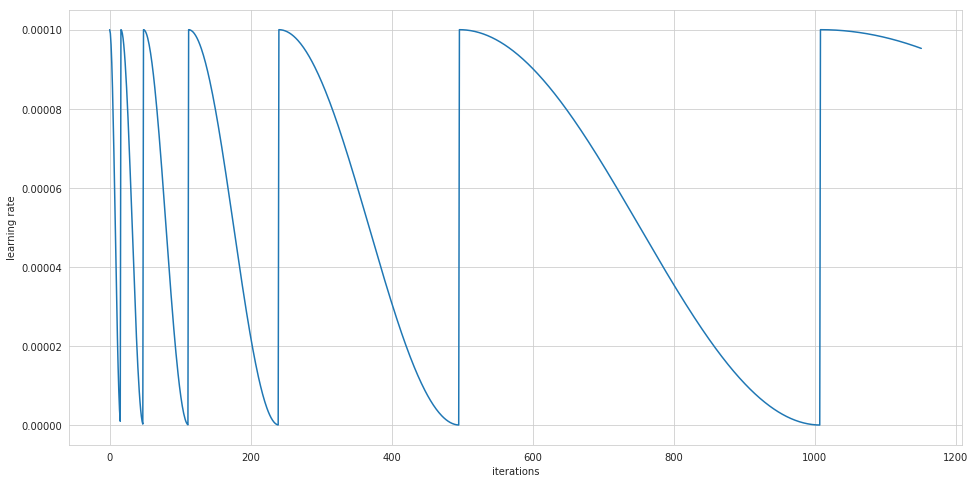

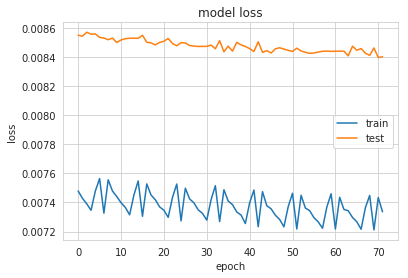

Fold took 1313.620s

Running fold 5 / 10
.
1 New best found: 0.0083770426749
.
2 New best found: 0.00832763586059
...
5 New best found: 0.00832265295638
......
11 New best found: 0.00831903369815
.....
16 New best found: 0.00829513621799
........
24 New best found: 0.00828863293916
.
25 New best found: 0.00828632919156
........
33 New best found: 0.00827967903428
.
34 New best found: 0.00827098355972
....
38 New best found: 0.00826754967362
...
41 New best found: 0.00826644246964
.
42 New best found: 0.00825933194641
.
43 New best found: 0.00825669342419
.
44 New best found: 0.00825546384219
...
47 New best found: 0.00823846120044
..................
65 New best found: 0.00823419352551
.Learning process stalled at 0.008285763560415944. Stopping...
.Learning process stalled at 0.008274084222561214. Stopping...
...
70 New best found: 0.00822502887444
..Score is: {'loss': 0.008225028874439886, 'AUC': 0.17446894981465, 'cut': 0.25415948033332825, 'wAUC': 0.17446894981465, 'AMS': 455.8117142

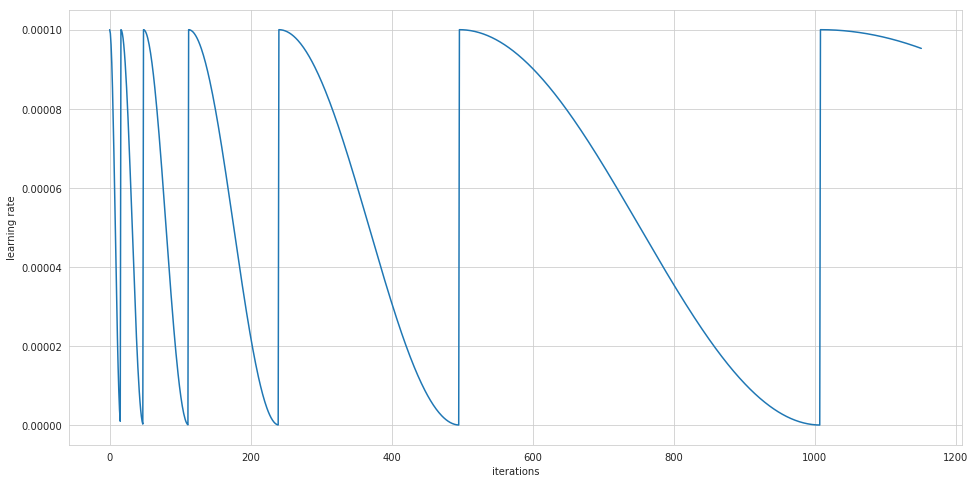

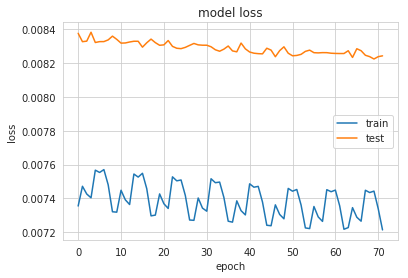

Fold took 796.935s

Running fold 6 / 10
.
1 New best found: 0.00829452491159
.......
8 New best found: 0.00829120631146
..
10 New best found: 0.00828716193215
......
16 New best found: 0.0082754435275
...
19 New best found: 0.00826592110819
.......
26 New best found: 0.00825685093927
......Learning process stalled at 0.00841489460039884. Stopping...
..
34 New best found: 0.00825177569941
.
35 New best found: 0.00822746119081
.Score is: {'loss': 0.008227461190806935, 'AUC': 0.1741428999748581, 'cut': 0.1444767266511917, 'wAUC': 0.1741428999748581, 'AMS': 457.4849355951786}


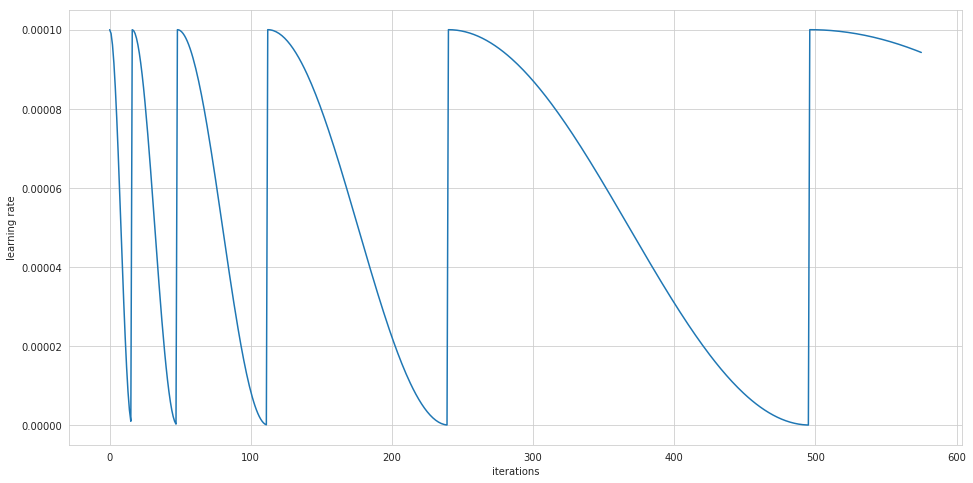

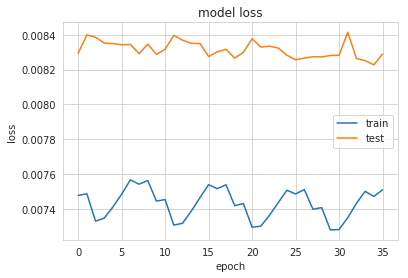

Fold took 331.045s

Running fold 7 / 10
.
1 New best found: 0.00841085386506
.
2 New best found: 0.0083828507213
........
10 New best found: 0.00835822805646
.........
19 New best found: 0.00832857828517
.................Learning process stalled at 0.008400685296481242. Stopping...
Score is: {'loss': 0.008328578285174444, 'AUC': 0.17618288432535456, 'cut': 0.08739042282104492, 'wAUC': 0.17618288432535456, 'AMS': 454.4506044181311}


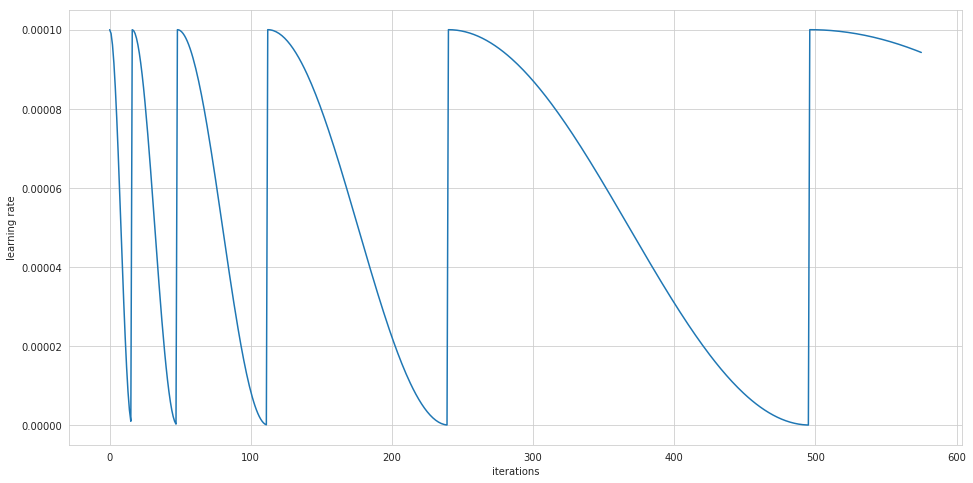

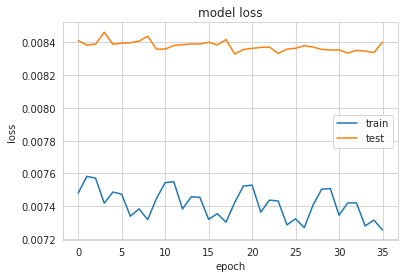

Fold took 510.230s

Running fold 8 / 10
.
1 New best found: 0.00815052289836
.
2 New best found: 0.00813749388925
.....
7 New best found: 0.0081355964456
.
8 New best found: 0.00813159836869
.
9 New best found: 0.00811510217385
...
12 New best found: 0.00811177133836
....
16 New best found: 0.00810347861114
..
18 New best found: 0.00809756672367
.
19 New best found: 0.00809581280962
..
21 New best found: 0.00809055898213
....
25 New best found: 0.00808276995802
...
28 New best found: 0.0080804145365
......
34 New best found: 0.00807426630983
..
36 New best found: 0.00806428172888
..
38 New best found: 0.00805808394675
.
39 New best found: 0.00805791255922
...
42 New best found: 0.0080573201372
...
45 New best found: 0.00804732348592
.
46 New best found: 0.00804327165012
......
52 New best found: 0.00804237991845
...
55 New best found: 0.008042143946
.........
64 New best found: 0.00803594470137
...Learning process stalled at 0.008070885510291767. Stopping...
...
70 New best found: 0.00

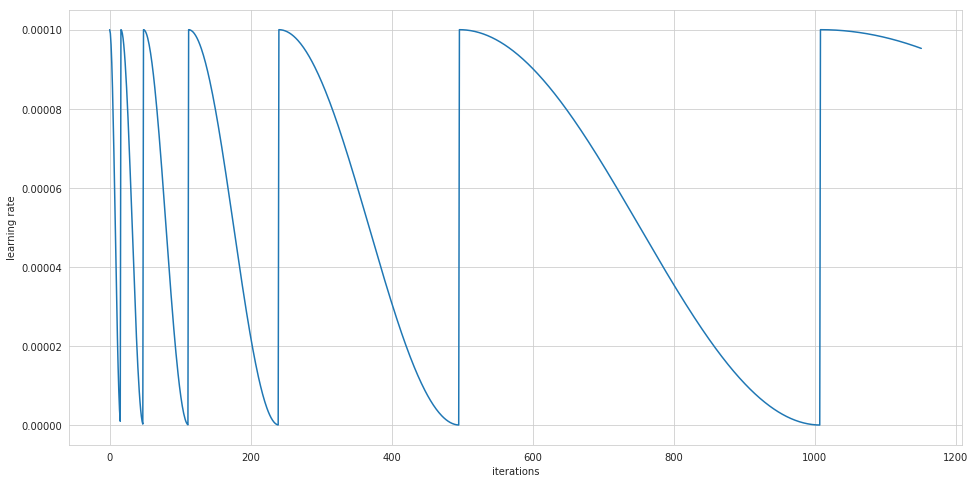

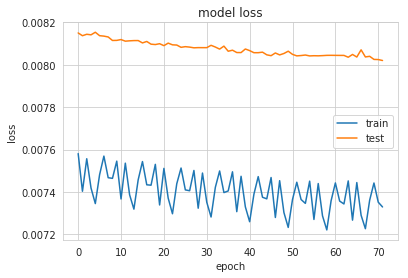

Fold took 800.205s

Running fold 9 / 10
.
1 New best found: 0.0085285889507
.
2 New best found: 0.00848896191833
..
4 New best found: 0.0084780983014
....
8 New best found: 0.00846424006599
......
14 New best found: 0.00846266314644
...
17 New best found: 0.00845670068462
...
20 New best found: 0.00844878524663
.
21 New best found: 0.00843981877762
..............
35 New best found: 0.00843365628703
.
36 New best found: 0.00843290867298
.Learning process stalled at 0.008487044854228023. Stopping...
.
38 New best found: 0.00840030877156
..
40 New best found: 0.00839631964681
.....Score is: {'loss': 0.008396319646807187, 'AUC': 0.17846802072995493, 'cut': 0.15054036676883698, 'wAUC': 0.17846802072995493, 'AMS': 453.545133234898}


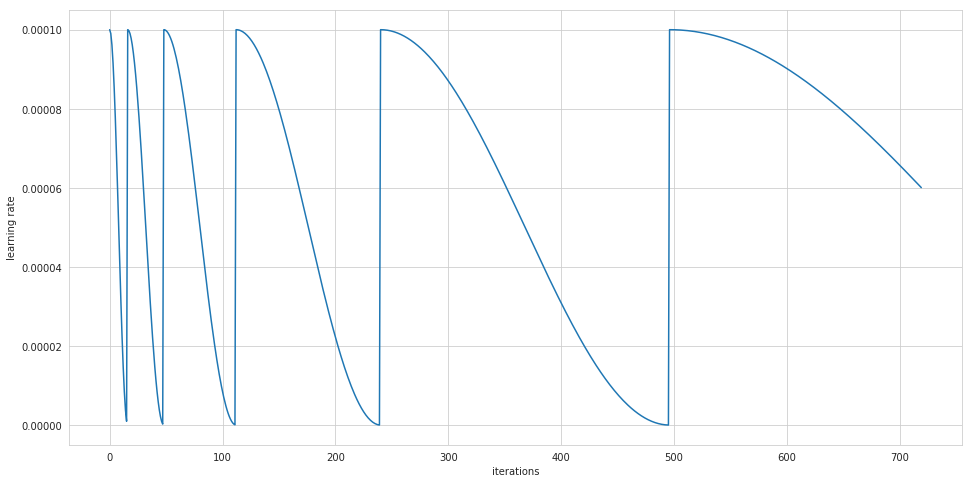

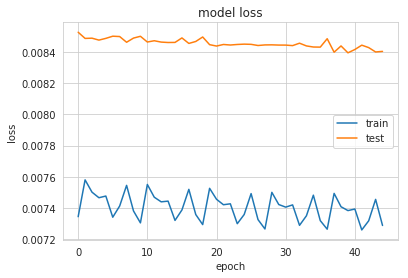

Fold took 404.653s

Running fold 10 / 10
.
1 New best found: 0.00836357169954
.
2 New best found: 0.00827677614278
.
3 New best found: 0.00827220211036
.....
8 New best found: 0.00827201676475
...
11 New best found: 0.0082493965241
.........
20 New best found: 0.00823808417075
.
21 New best found: 0.00822529458845
..............
35 New best found: 0.00820951617849
..
37 New best found: 0.0082085681202
.
38 New best found: 0.00819588983849
......
44 New best found: 0.00819189330389
...
47 New best found: 0.00817623289314
.
48 New best found: 0.00817424664117
.................
65 New best found: 0.00815971064261
......
71 New best found: 0.00815327470384
..
73 New best found: 0.0081436115464
.
74 New best found: 0.00814297100757
.
75 New best found: 0.00813383370694
.......
82 New best found: 0.00812099529173
.
83 New best found: 0.00811774726822
.
84 New best found: 0.00811434537576
.......
91 New best found: 0.00810365936037
.
92 New best found: 0.00810266054369
.
93 New best found: 0.

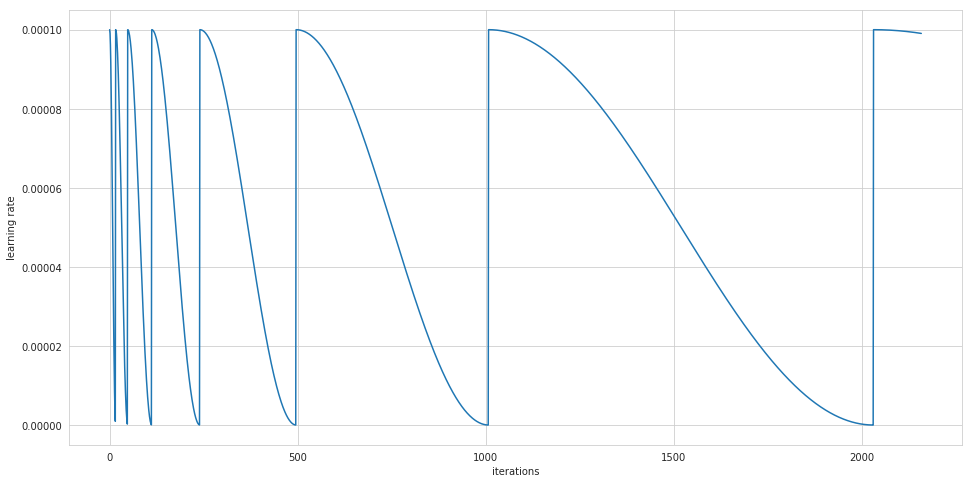

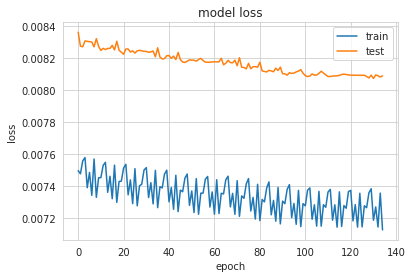

Fold took 1213.680s


______________________________________
Training finished
Cross-validation took 9019.444s 
Mean loss = 162197 +- 153874
Mean AUC = 0.174 +- 0.001
Mean cut = 0.13 +- 0.03
Mean wAUC = 0.174 +- 0.001
Mean AMS = 458 +- 2
______________________________________



In [12]:
results, histories = batchTrainClassifier(trainDataTargetMod, nSplits, newGetModel, newModelArgs,
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          cosAnnealMult=2, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000, binary=True,
                                          plotLR=plot_while_training, # plotMomentum=plot_while_training, 
                                          plot=plotLoss, 
                                          stopIfStallingTest=30,
                                         )

In [15]:
n = name_pretrain+'_model'

In [17]:
#model.save(n+'.h5')
with open(n+'.pkl', 'w') as f:
    pickle.dump((results, histories), f)

In [ ]:
#model = load_model(n+'.h5', custom_objects=new_loss_functions)
with open(n+'.pkl') as f:
    results, histories = pickle.load(f)

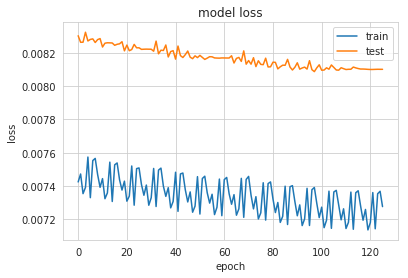

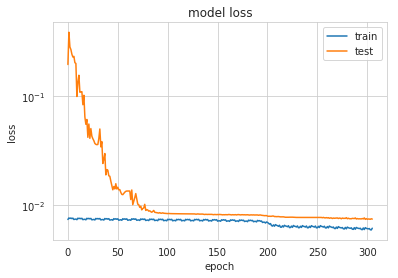

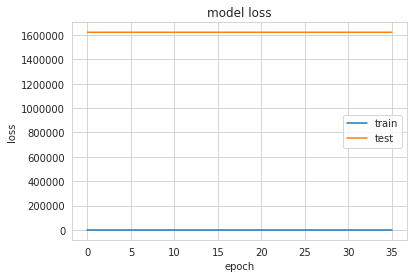

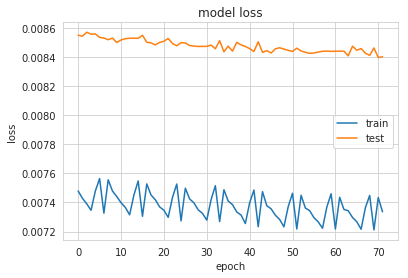

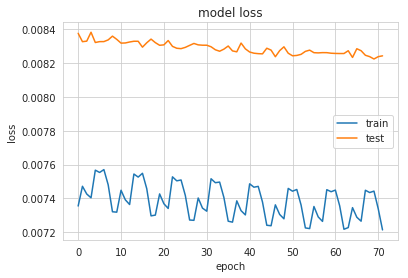

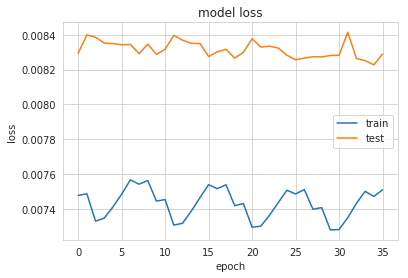

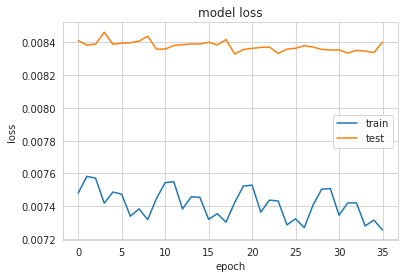

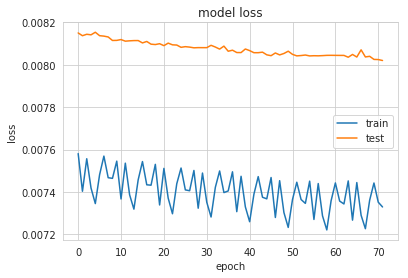

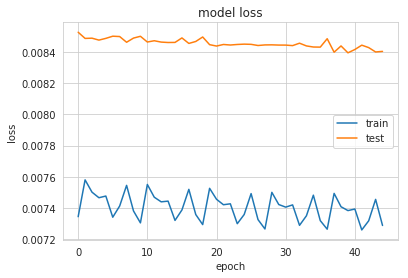

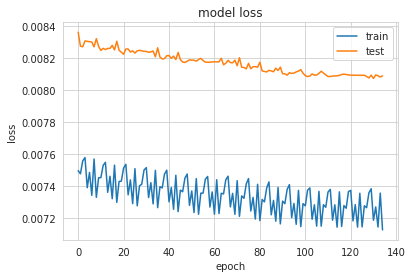

In [18]:
for i in range(len(histories)):
    plotLoss(histories[i])

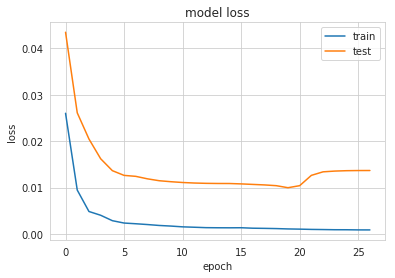

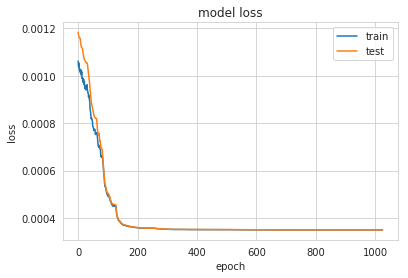

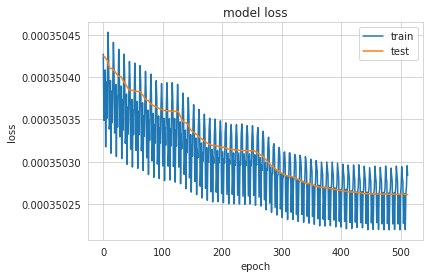

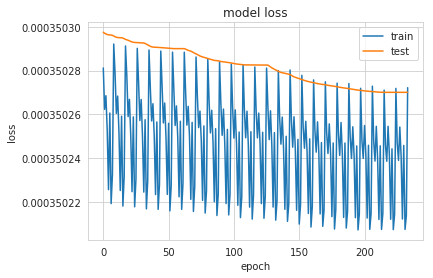

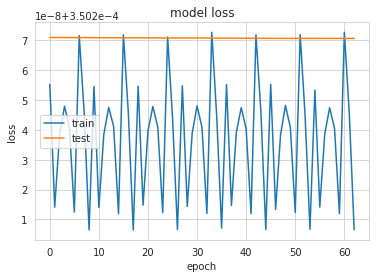

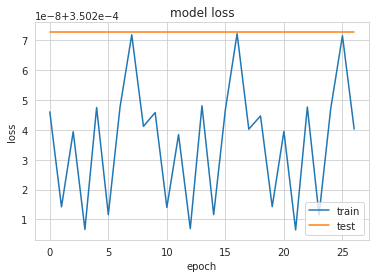

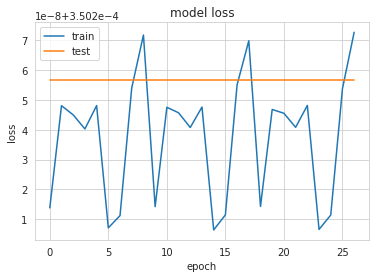

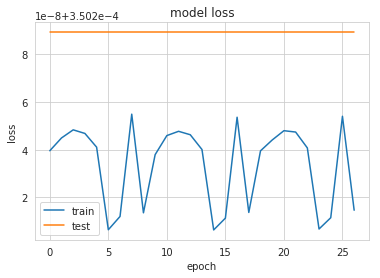

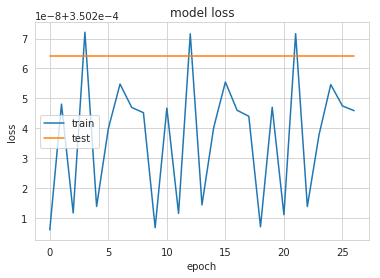

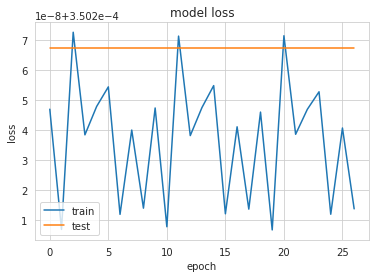

## Construct ensemble

In [19]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [20]:
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 1, 'with', 'loss', '=', 0.007362092141727128)
('Model', 1, 'is', 7, 'with', 'loss', '=', 0.008020486270092494)
('Model', 2, 'is', 9, 'with', 'loss', '=', 0.008073550956548062)
('Model', 3, 'is', 0, 'with', 'loss', '=', 0.008087326858010115)
('Model', 4, 'is', 4, 'with', 'loss', '=', 0.008225028874439886)
('Model', 5, 'is', 5, 'with', 'loss', '=', 0.008227461190806935)
('Model', 6, 'is', 6, 'with', 'loss', '=', 0.008328578285174444)
('Model', 7, 'is', 8, 'with', 'loss', '=', 0.008396319646807187)
('Model', 8, 'is', 3, 'with', 'loss', '=', 0.008397295634902548)
('Model', 9, 'is', 2, 'with', 'loss', '=', 1621973.5125970924)


## Response on validation datawith no ensembling

In [22]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [23]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 5.19073775759e-05s per sample

Predicting batch 2 out of 10
Prediction took 4.57849797895e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.93490192164e-05s per sample

Predicting batch 4 out of 10
Prediction took 3.811727557e-05s per sample

Predicting batch 5 out of 10
Prediction took 4.28967177868e-05s per sample

Predicting batch 6 out of 10
Prediction took 4.04524430633e-05s per sample

Predicting batch 7 out of 10
Prediction took 4.11429074843e-05s per sample

Predicting batch 8 out of 10
Prediction took 3.84789883537e-05s per sample

Predicting batch 9 out of 10
Prediction took 4.60745040363e-05s per sample

Predicting batch 10 out of 10
Prediction took 4.02608503867e-05s per sample

CPU times: user 1min 5s, sys: 3min 40s, total: 4min 45s
Wall time: 13.6 s


In [24]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.833694559865, weighted 0.833694559865


In [11]:
%%time
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')
CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 41.5 s


(3.574477842890102, 0.9527582)

In [12]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.6+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.947619539453, corresponds to AMS of 3.52228979407
CPU times: user 2.71 s, sys: 10 s, total: 12.7 s
Wall time: 57.8 s


(3.6, 0.95)

# Test scoring with no ensembling

In [20]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [21]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 3.52311047641e-05s per sample

Predicting batch 2 out of 10
Prediction took 3.53069262071e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.40793089433e-05s per sample

Predicting batch 4 out of 10
Prediction took 3.57414549047e-05s per sample

Predicting batch 5 out of 10
Prediction took 4.16354005987e-05s per sample

Predicting batch 6 out of 10
Prediction took 3.62087639895e-05s per sample

Predicting batch 7 out of 10
Prediction took 3.70459816673e-05s per sample

Predicting batch 8 out of 10
Prediction took 3.47492521459e-05s per sample

Predicting batch 9 out of 10
Prediction took 3.80688537251e-05s per sample

Predicting batch 10 out of 10
Prediction took 3.47301613201e-05s per sample

CPU times: user 1min 44s, sys: 5min 43s, total: 7min 27s
Wall time: 20 s


In [44]:
scoreTestOD(testData.source, 0.9417530075879768)

Public:Private AMS: 3.18253691892 : 3.22240702412


(3.1825369189224144, 3.222407024124467)

## Response on validation data with ensembling

In [31]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [32]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00130655798912s per sample

Predicting batch 2 out of 10
Prediction took 0.000384625196457s per sample

Predicting batch 3 out of 10
Prediction took 0.000401422405243s per sample

Predicting batch 4 out of 10
Prediction took 0.000396262168884s per sample

Predicting batch 5 out of 10
Prediction took 0.000394056797028s per sample

Predicting batch 6 out of 10
Prediction took 0.00038629360199s per sample

Predicting batch 7 out of 10
Prediction took 0.000385829401016s per sample

Predicting batch 8 out of 10
Prediction took 0.000377050590515s per sample

Predicting batch 9 out of 10
Prediction took 0.000388145446777s per sample

Predicting batch 10 out of 10
Prediction took 0.000397673797607s per sample

CPU times: user 1min 54s, sys: 5min 53s, total: 7min 48s
Wall time: 24.1 s


In [18]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.897939621566, weighted 0.933283232346


In [19]:
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')


(3.715117458996407, 0.9555341)

In [20]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.8+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.950024582446, corresponds to AMS of 3.69339872363
CPU times: user 2.59 s, sys: 9.73 s, total: 12.3 s
Wall time: 56.6 s


(3.8, 0.95)

# Test scoring

In [15]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [16]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000381626436927s per sample

Predicting batch 2 out of 10
Prediction took 0.000325065690821s per sample

Predicting batch 3 out of 10
Prediction took 0.000332086307352s per sample

Predicting batch 4 out of 10
Prediction took 0.000326267415827s per sample

Predicting batch 5 out of 10
Prediction took 0.000327129546079s per sample

Predicting batch 6 out of 10
Prediction took 0.000323580308394s per sample

Predicting batch 7 out of 10
Prediction took 0.000327063855258s per sample

Predicting batch 8 out of 10
Prediction took 0.000326154544137s per sample

Predicting batch 9 out of 10
Prediction took 0.000326552473415s per sample

Predicting batch 10 out of 10
Prediction took 0.000326488633589s per sample

CPU times: user 15min 57s, sys: 52min 37s, total: 1h 8min 35s
Wall time: 3min 2s


In [23]:
scoreTestOD(testData.source, 0.9394347775960341)

Public:Private AMS: 3.6170575304 : 3.61021225312


(3.6170575303988963, 3.610212253117004)

# Save/Load

In [23]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=True)

TypeError: <function asimovSignificanceLossInvert_Sys0p5_S6d92ep02_B4d11ep05 at 0x7f1d310197d0> is not JSON serializable

In [6]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name, custom_objects=new_loss_functions)

# Plotting

(320000, 'candidates loaded')


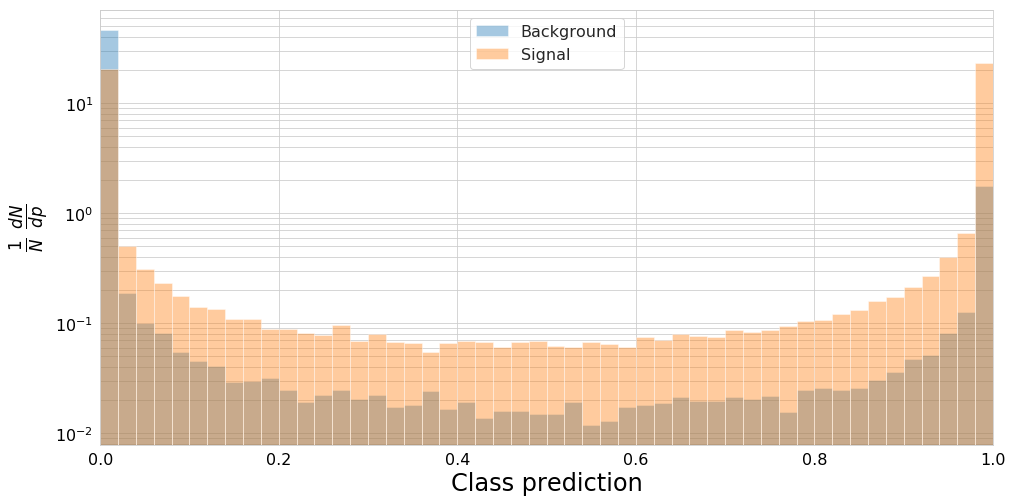

In [25]:
# TODO log-x

d = convertToDF(valData.source)
bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='gen_weight')

(320000, 'candidates loaded')
0 ROC AUC: 0.833694559865


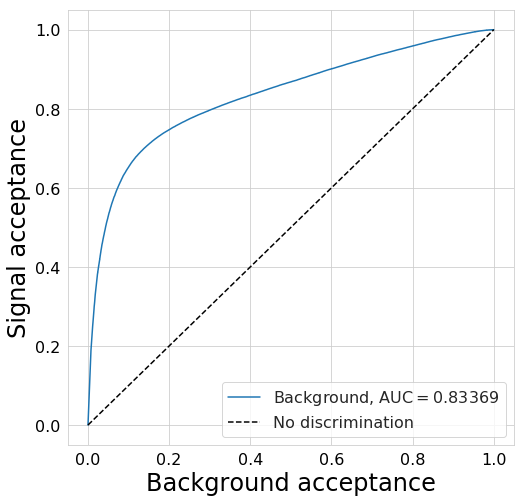

In [26]:
rocPlot([convertToDF(valData.source)], weightName='gen_weight', labels=['Background', 'Signal'])

(320000, 'candidates loaded')


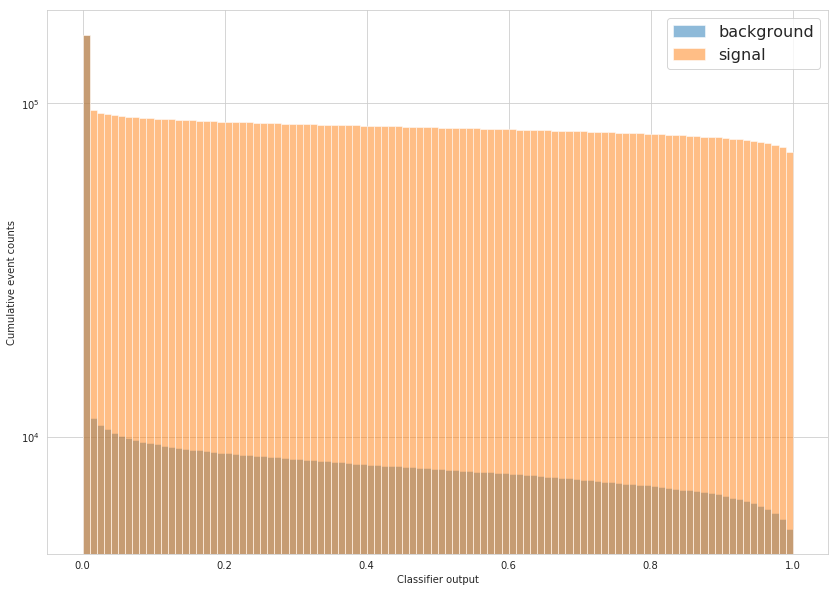

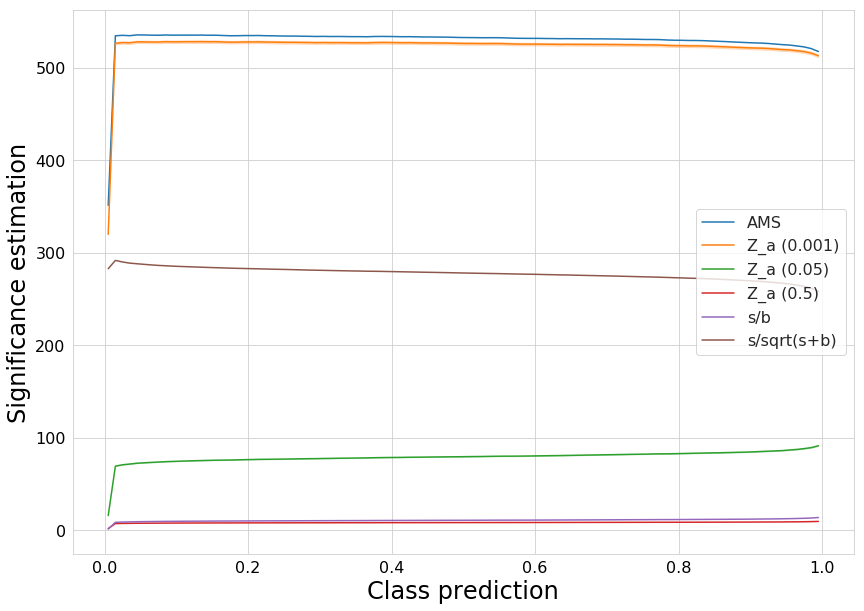

In [27]:
src = valData
#src = testData

from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), eZ_asimov(s,sqrt(s),b,sqrt(b),systematic))

h1 = plotSignificanceEstimate(
    convertToDF(src.source), 
    {
        's/b': lambda s,b: s/b,
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.05)': get_asimov(0.05),
        'Z_a (0.001)': get_asimov(0.001),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='gen_weight',
    figsize=(14, 10),
    nBins=100,
)